In [1]:
#combine CDC and flu data
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress
import scipy.stats as stats
import seaborn as sns

In [2]:
#load CSVs
wdf =[]
wdf = pd.read_csv("Complied_Weather.csv")
idf = pd.read_csv("Data/ILI Totals for Desired States.csv")

In [3]:
#replace wdf states with full name
wdf['State'].replace({'AZ':'Arizona','CA':'California','CO':'Colorado','GA':'Georgia','IL':'Illinois','NY':'New York',
                      'PA':'Pennsylvania','TX':'Texas','WA':'Washington'},inplace=True)

wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_day_of_the_week  6589 non-null   object 
 1   average_temperature   6589 non-null   float64
 2   week                  6589 non-null   int64  
 3   year                  6589 non-null   int64  
 4   State                 6589 non-null   object 
 5   City                  6589 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 309.0+ KB


In [4]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   State     4545 non-null   object
 1   year      4545 non-null   int64 
 2   week      4545 non-null   int64 
 3   ILITOTAL  4545 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 142.2+ KB


In [5]:
#Merge weather df and ILI df and save as CSV
widf = pd.merge(idf,wdf,on=['State','week','year'])

In [6]:
#Convert last_day_of_the_week to datetime and add column
widf['ldw_num'] = widf.loc[:,'last_day_of_the_week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
widf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5544 entries, 0 to 5543
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   State                 5544 non-null   object        
 1   year                  5544 non-null   int64         
 2   week                  5544 non-null   int64         
 3   ILITOTAL              5544 non-null   int64         
 4   last_day_of_the_week  5544 non-null   object        
 5   average_temperature   5544 non-null   float64       
 6   City                  5544 non-null   object        
 7   ldw_num               5544 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 389.8+ KB


In [7]:
#Form new dataframe removing 2019-2020 flu season as COVID skewing data
DF_no2020 =widf[widf['ldw_num']<('2019-10-01')]
DF_no2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5148 entries, 0 to 5147
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   State                 5148 non-null   object        
 1   year                  5148 non-null   int64         
 2   week                  5148 non-null   int64         
 3   ILITOTAL              5148 non-null   int64         
 4   last_day_of_the_week  5148 non-null   object        
 5   average_temperature   5148 non-null   float64       
 6   City                  5148 non-null   object        
 7   ldw_num               5148 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 362.0+ KB


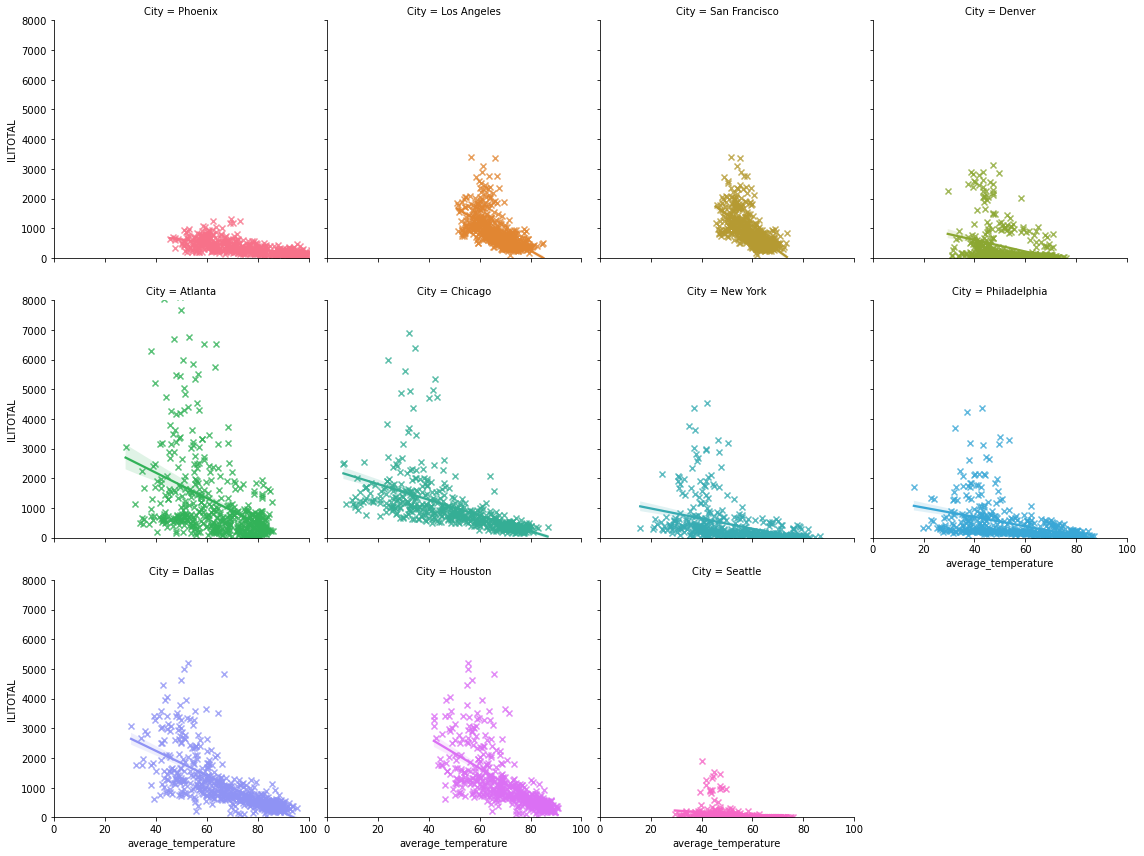

In [8]:
#Show scatter plot of each city with best fit line
grid_plot = sns.lmplot(x='average_temperature', y='ILITOTAL', col="City", hue="City",
                       data=widf, col_wrap = 4, height = 4, markers='x')
grid_plot.set(xlim=(0,100), ylim=(0,8000))

In [9]:
#Form unique list of cities
Cities = DF_no2020.City.unique()
Cities_df = pd.DataFrame(Cities, columns=['Cities'])
Cities_df

,Cities
0,Phoenix
1,Los Angeles
2,San Francisco
3,Denver
4,Atlanta
5,Chicago
6,New York
7,Philadelphia
8,Dallas
9,Houston


In [10]:
#Run for loop to get dataframe for each city; Return city index[5] - Chicago
dataframe = []
for city in range(len(Cities)):
    dataframe.append(DF_no2020[DF_no2020['City']==Cities[city]])
dataframe[5].head()

,State,year,week,ILITOTAL,last_day_of_the_week,average_temperature,City,ldw_num
5,Illinois,2010,40,505,2010-10-10,61.642857,Chicago,2010-10-10
16,Illinois,2010,41,600,2010-10-17,58.357143,Chicago,2010-10-17
27,Illinois,2010,42,644,2010-10-24,53.785714,Chicago,2010-10-24
38,Illinois,2010,43,623,2010-10-31,51.357143,Chicago,2010-10-31
49,Illinois,2010,44,625,2010-11-07,41.214286,Chicago,2010-11-07


In [11]:
#Pass each cities dataframe through loop to return regression results
#Form empty lists for x and y values for scatter plot/line plot
temp_values = []
ili_values = []
ldw_num_values = []

#Form empty lists to store regression values
slope_results = []
intercept_results = []
rvalue_results = []
regress_values = []
line_eq = []
r_squared = []

#Run for loop to get all regression values for each city
for variable in range(len(dataframe)):
    #Append x and y lists with temperature and ILI Total from individual city's dataframe
    temp_values.append(dataframe[variable]['average_temperature'])
    ili_values.append(dataframe[variable]['ILITOTAL'])
    ldw_num_values.append(dataframe[variable]['ldw_num'])
    
    #Perform the regression analysis on above variables and append each list for individual city
    [slope, intercept, rvalue, pvalue, stderr] = linregress(temp_values[variable], ili_values[variable])
    slope_results.append(slope)
    intercept_results.append(intercept)
    rvalue_results.append(rvalue)
    regress_values.append(temp_values[variable] * slope_results[variable] + intercept_results[variable])
    line_eq.append("y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)))
    r_squared.append("R^2 = " + str(round(rvalue**2,3)))

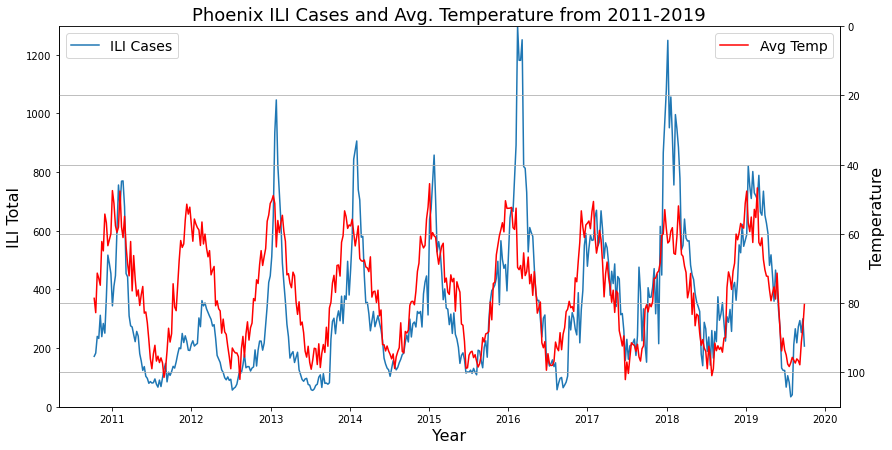

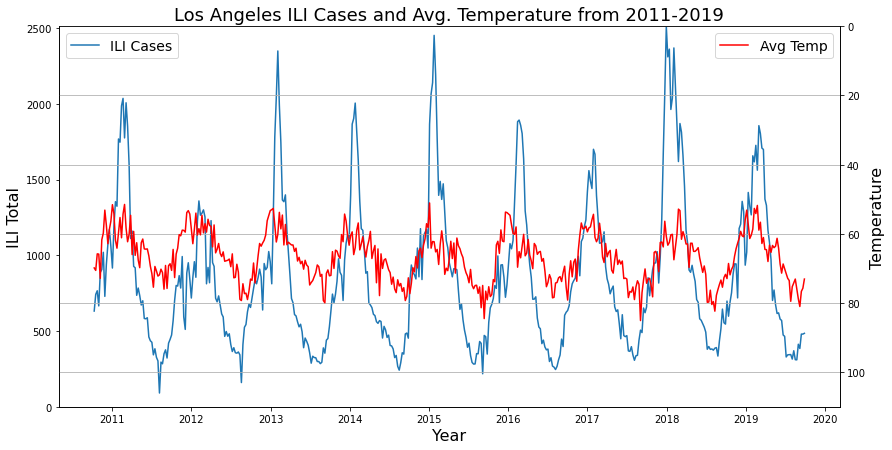

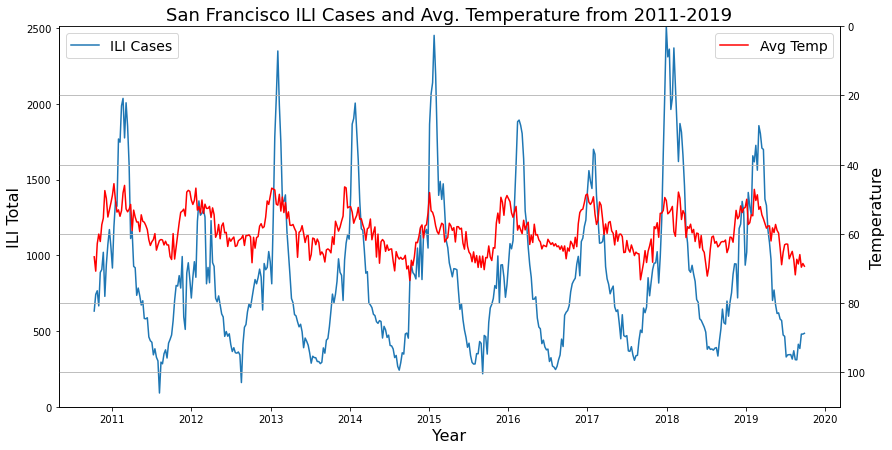

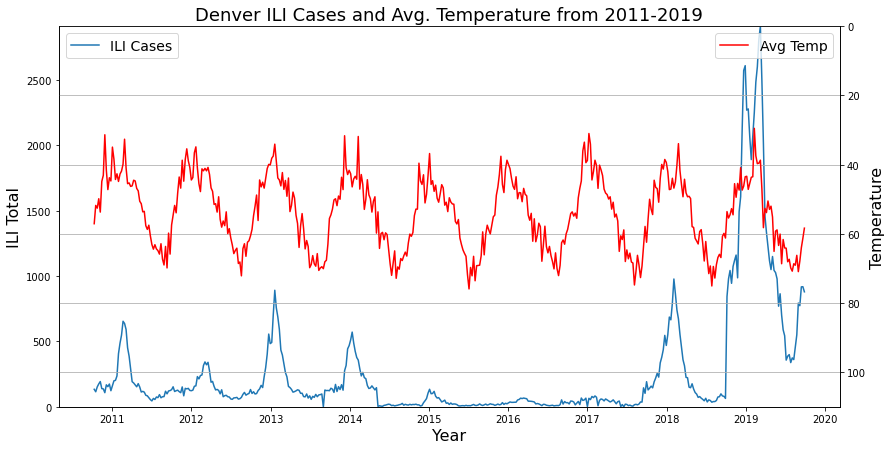

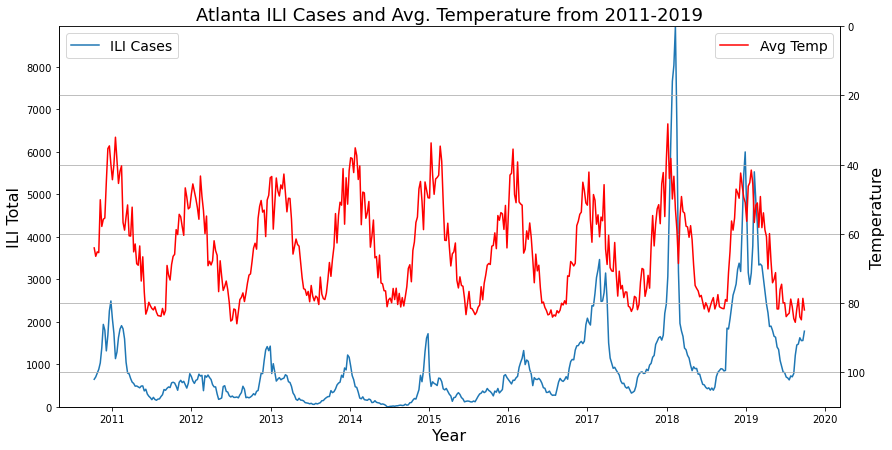

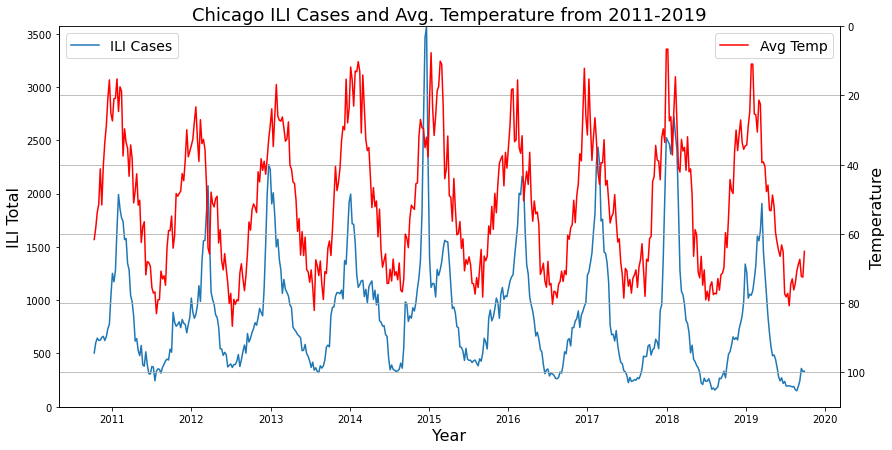

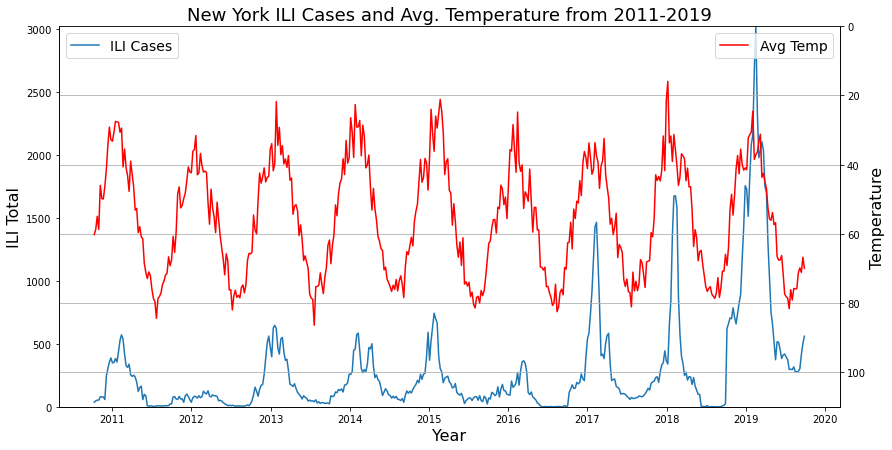

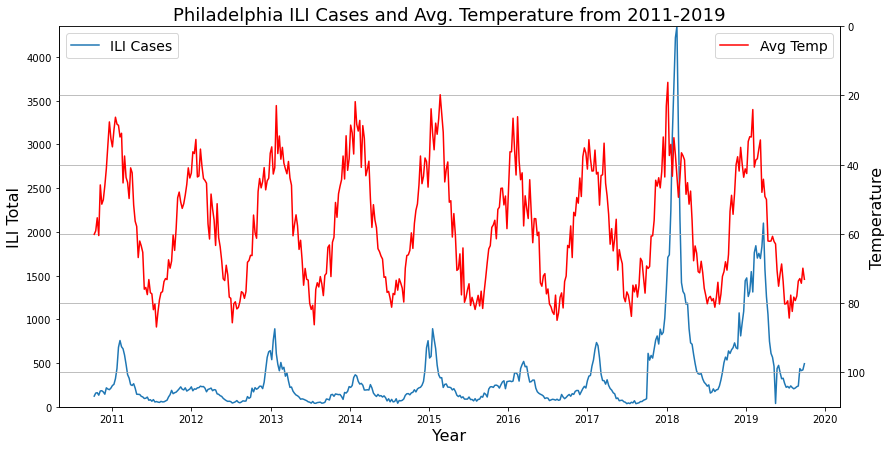

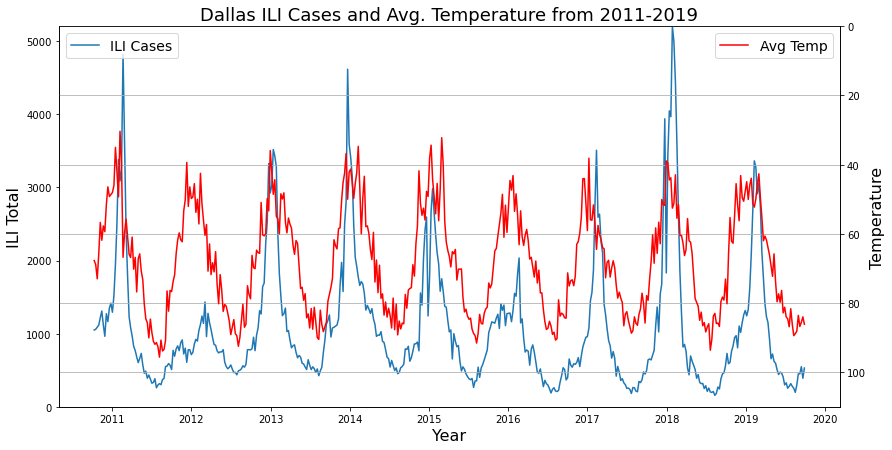

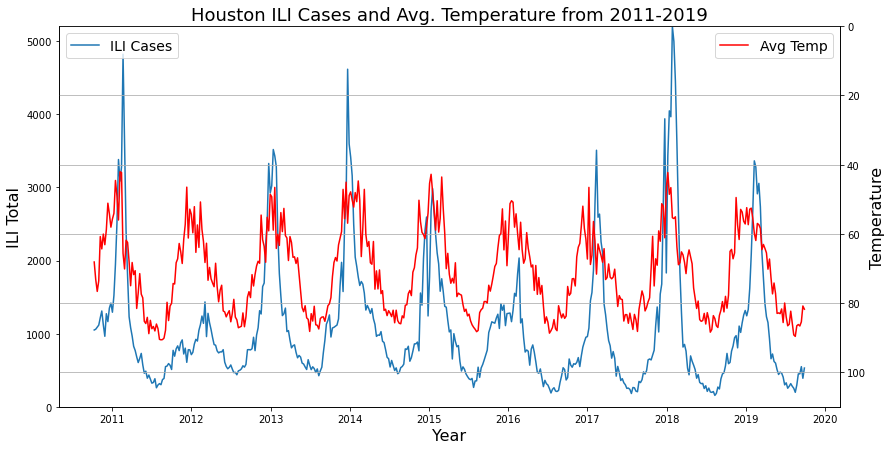

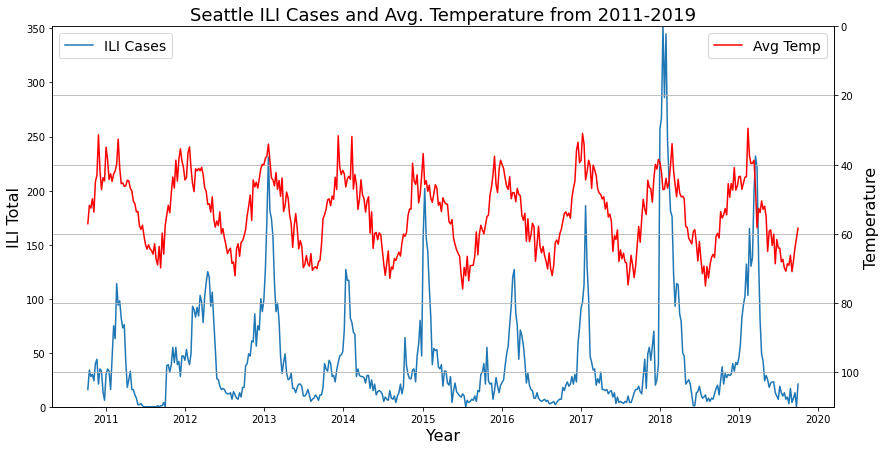

In [12]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(Cities)):
    #Form first plot using ILI cases by week
    fig, ax1 = plt.subplots()
    ax1.plot(ldw_num_values[city],ili_values[city], label='ILI Cases')
    plt.ylabel('ILI Total', fontsize = 16)
    plt.xlabel('Year', fontsize = 16)
    ax1.legend(loc='upper left',fontsize = 14)
    plt.ylim((0,ili_values[city].max()))

    #Form second plot using same x-axis but secondary y-axis for average temperature
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.plot(ldw_num_values[city],temp_values[city], label='Avg Temp',color ='red')
    plt.ylim((0,110))
    plt.gca().invert_yaxis() #invert y-axis so trend is similar
    plt.ylabel('Temperature', fontsize = 16)
    ax2.legend(fontsize = 14)

    #Show dual plot w/ grid
    plt.grid(True)
    plt.title(f'{Cities[city]} ILI Cases and Avg. Temperature from 2011-2019', fontsize = 18)
    fig.set_size_inches(14, 7, forward=True)
    filepath = (f'Plots/Line_Plots/{Cities[city]} ILI Cases and Avg. Temperature from 2011-2019.png')
    plt.savefig(filepath)
plt.show()

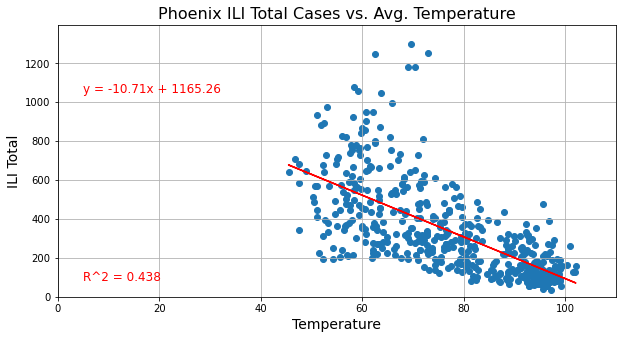

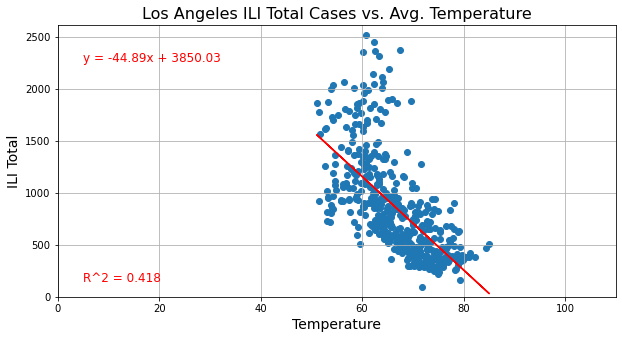

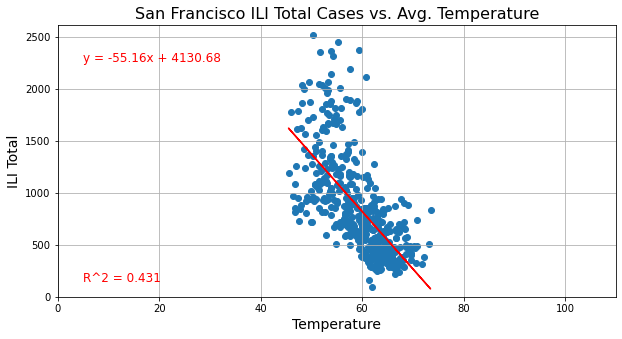

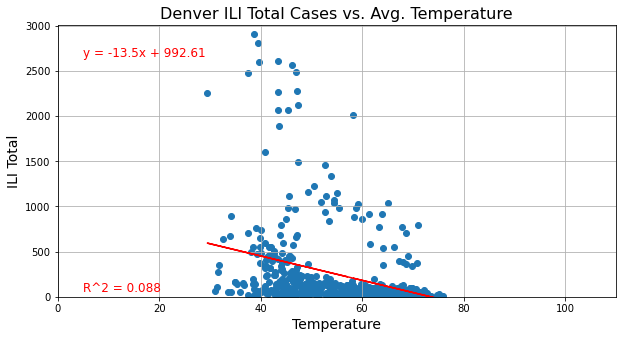

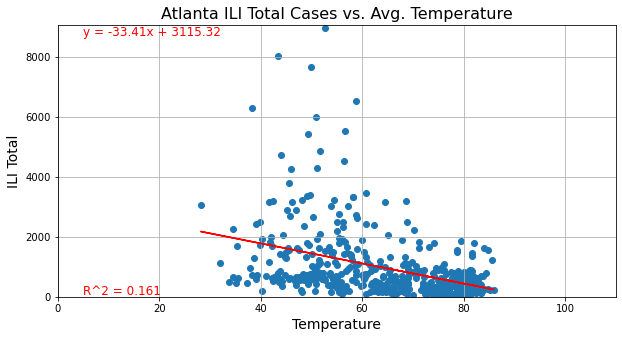

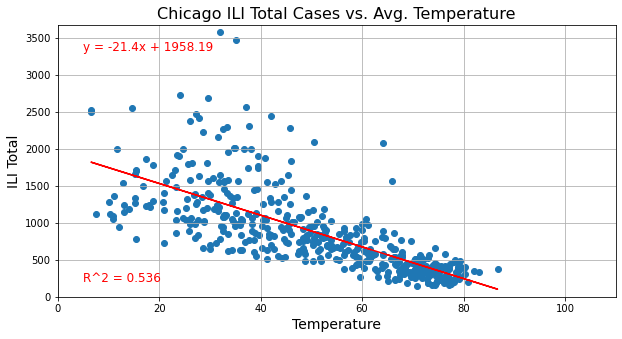

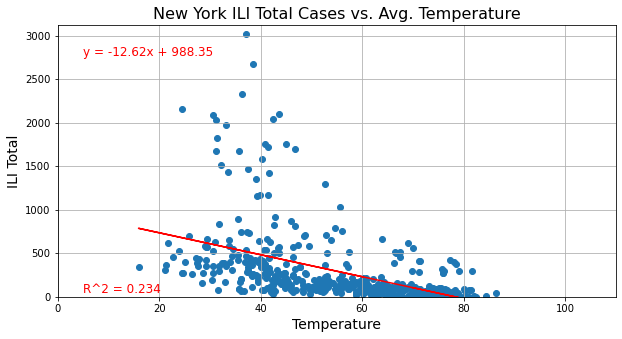

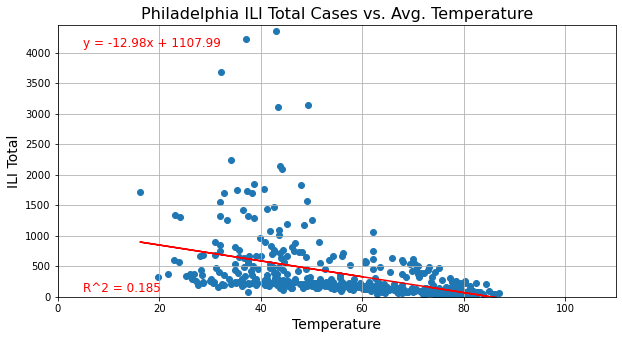

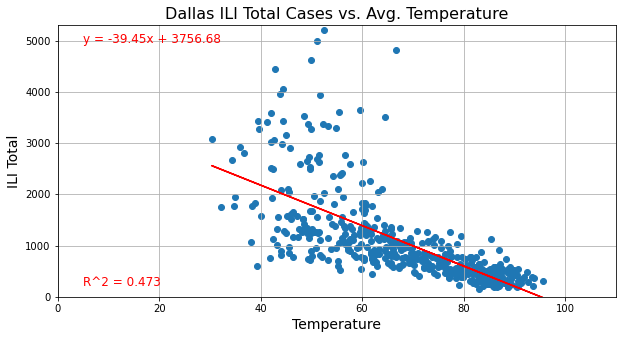

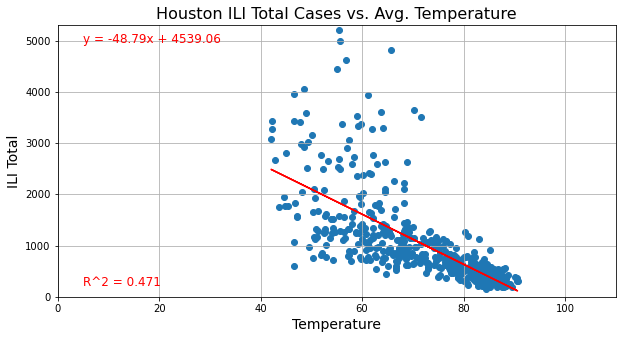

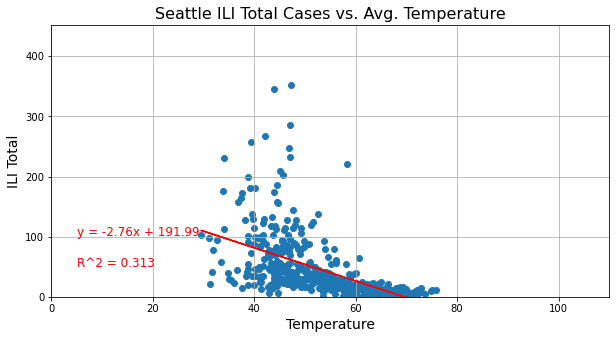

In [13]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(Cities)):
    plt.figure(figsize=(10,5))
    plt.scatter(temp_values[city],ili_values[city])
    plt.grid(True)
    plt.plot(temp_values[city],regress_values[city],"r-")
    plt.annotate(line_eq[city],(5,ili_values[city].max()-250),fontsize=12,color='r')
    plt.annotate(r_squared[city],(5,ili_values[city].min()+50),fontsize=12, color='r')
    plt.ylabel('ILI Total', fontsize = 14)
    plt.ylim((0,ili_values[city].max()+100))
    plt.xlabel('Temperature', fontsize = 14)
    plt.xlim((0,110))
    plt.title(f'{Cities[city]} ILI Total Cases vs. Avg. Temperature', fontsize=16)
    filepath = (f'Plots/Scatter_Plots/{Cities[city]} ILI Total Cases vs. Avg. Temperature.png')
    plt.savefig(filepath)
plt.show()

In [14]:
stats.ttest_ind(temp_values[5],ili_values[5], equal_var=False)

Ttest_indResult(statistic=-31.385453542791126, pvalue=3.2014081837628565e-117)